<a href="https://www.kaggle.com/code/somewhatjustin/titanic?scriptVersionId=164933975" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
'''
TODO: 
- make cabin category more useful
'''

'\nTODO: \n- make cabin category more useful\n'

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
# Combine parch and sibsp into fam
train_data['fam'] = train_data['Parch']+train_data['SibSp']
test_data['fam'] = test_data['Parch']+test_data['SibSp']

def isAlone(fam):
    if fam == 0:
        return True
    else:
        return False

# Check if alone
train_data['alone'] = train_data['fam'].apply(isAlone)
test_data['alone'] = test_data['fam'].apply(isAlone)

In [5]:
# Give Titles
def categorize_name(name):
    if 'Mr.' in name:
        return 'Mr'
    elif 'Master' in name:
        return 'Master'
    elif 'Col.' in name or 'Major.' in name or 'Capt.' in name:
        return 'Military'
    elif 'Miss' in name or 'Ms.' in name or 'Mlle.' in name:
        return 'Miss'
    elif 'Mrs.' in name or 'Mme.' in name:
        return 'Misses'
    elif 'Rev.' in name:
        return 'Reverend'
    elif 'Dr.' in name:
        return 'Doctor'
    elif 'Don.' in name or 'Lady.' in name or 'Sir.' in name or 'Countess.' in name or 'Jonkheer.' in name:
        return 'Royalty'
    else:
        return 'Other'

train_data['Title'] = train_data['Name'].apply(categorize_name)
test_data['Title'] = test_data['Name'].apply(categorize_name)

train_data[train_data['Title']=="Other"].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fam,alone,Title


In [6]:
# Bucket Age

# Fill NaNs without using inplace=True
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].mean())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].mean())

# Create age buckets
age_buckets = np.linspace(0,80,20)
train_data['Age_bucket'] = pd.cut(train_data['Age'], age_buckets)
test_data['Age_bucket'] = pd.cut(test_data['Age'], age_buckets)

buckets, blah = pd.factorize(train_data['Age_bucket'])
train_data['Age_bucket'] = buckets
buckets, blah = pd.factorize(test_data['Age_bucket'])
test_data['Age_bucket'] = buckets

#train_data['Age_normalized'] = scaler.fit_transform(train_data[['Age']].values.reshape(-1, 1))
#test_data['Age_normalized'] = scaler.transform(test_data[['Age']].values.reshape(-1, 1))

train_data.head(30)

# Note: Use scaler.fit_transform() on the training data to fit the scaler and transform the data.
# Use scaler.transform() on the test data to apply the same scaling based on the training data.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fam,alone,Title,Age_bucket
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,False,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,False,Misses,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,True,Miss,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,False,Misses,3
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,True,Mr,3
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,0,True,Mr,4
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,0,True,Mr,5
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,4,False,Master,6
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,2,False,Misses,2
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C,1,False,Misses,7


In [7]:
# Fare Normalization

# Fill NaNs without using inplace=True
train_data['Fare'] = train_data['Fare'].fillna(train_data['Fare'].median())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

In [8]:
# Passenger Class Normalization

class_mapping = {1: "First", 2: "Second", 3: "Third"}
train_data['Pclass'] = train_data['Pclass'].map(class_mapping)
test_data['Pclass'] = test_data['Pclass'].map(class_mapping)

In [9]:
# Make sex binary

# 2: female
# 1: male

sex_mapping = {"male": 1, "female": 2}
train_data['Sex'] = train_data['Sex'].map(sex_mapping)
test_data['Sex'] = test_data['Sex'].map(sex_mapping)

In [10]:
# Cabin Classifier

def cabin_category(cabin):
    # Check for missing cabin information
    if pd.isnull(cabin):
        return 'Other'
    else:
        # Search for specific letters in the cabin string
        for letter in ['A', 'B', 'C', 'D', 'E', 'F']:
            if letter in cabin:
                return letter
        # Return 'Other' if none of the specific letters are found
        return 'Other'

# Apply the function to create a new 'Cabin_Category' column
train_data['Cabin_Category'] = train_data['Cabin'].apply(cabin_category)
test_data['Cabin_Category'] = test_data['Cabin'].apply(cabin_category)

In [11]:
# Analysis

# Now create a pivot table with the new 'Cabin_Category'
pivot_table = pd.crosstab(index=train_data['Survived'], columns=train_data['Cabin_Category'])

# Display the pivot table
print(pivot_table)

Cabin_Category  A   B   C   D   E  F  Other
Survived                                   
0               8  12  24   8   8  5    484
1               7  35  35  25  25  7    208


In [12]:
y = train_data["Survived"]

#features = ["Pclass", "Sex", "Age_bucket", "Fare", "alone", "Embarked", "fam", "Cabin_Category"]
features = ["Pclass", "Sex", "Age", "Fare", "alone", "Embarked", "fam", "Title"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])


# Ensure X_test has all the columns that X has, and fill missing ones with 0
for column in X.columns:
    if column not in X_test.columns:
        X_test[column] = 0  # Adding missing column in test data with default value of 0

# Align the order of X_test columns to match X
X_test = X_test[X.columns]

#model = GradientBoostingClassifier(n_estimators=150, max_depth=3).fit(X, y)
model = RandomForestClassifier(n_estimators=50, max_depth=4).fit(X,y)
submissionPredictions = model.predict(X_test)

In [13]:
# CHECK FOR OVERFITTING
from sklearn.metrics import accuracy_score

training_predictions = model.predict(X)
training_truth = y.to_numpy()

accuracy = accuracy_score(training_truth, training_predictions)
print(f"Accuracy:{accuracy}")

Accuracy:0.835016835016835


In [14]:
# CROSS-VALIDATION
from sklearn.model_selection import GridSearchCV

n_estimators = np.linspace(10, 100, 50, dtype="int")
para_grid = {'n_estimators': n_estimators, 'max_features': ["sqrt", "log2", None, 1, 2, 3, 4, 5, 6, 7, 8]}

print(n_estimators)

#clf = GridSearchCV(estimator=model, param_grid=para_grid, cv=5, n_jobs=-1)
#clf.fit(X,y)

[ 10  11  13  15  17  19  21  22  24  26  28  30  32  33  35  37  39  41
  43  44  46  48  50  52  54  55  57  59  61  63  65  66  68  70  72  74
  76  77  79  81  83  85  87  88  90  92  94  96  98 100]


In [15]:
'''
sorted_keys = sorted(clf.cv_results_.keys())  # Uncomment after fitting
print(sorted_keys)  # Uncomment after fitting

# Assuming `clf` is your GridSearchCV object and has been fitted with data
best_model = clf.best_estimator_

# To get the best score achieved during the cross-validation
best_score = clf.best_score_

# To see the parameters that yielded the best results
best_params = clf.best_params_

print("Best Score:", best_score)
print("Best Parameters:", best_params)
print("Best Model:", best_model)
'''

'\nsorted_keys = sorted(clf.cv_results_.keys())  # Uncomment after fitting\nprint(sorted_keys)  # Uncomment after fitting\n\n# Assuming `clf` is your GridSearchCV object and has been fitted with data\nbest_model = clf.best_estimator_\n\n# To get the best score achieved during the cross-validation\nbest_score = clf.best_score_\n\n# To see the parameters that yielded the best results\nbest_params = clf.best_params_\n\nprint("Best Score:", best_score)\nprint("Best Parameters:", best_params)\nprint("Best Model:", best_model)\n'

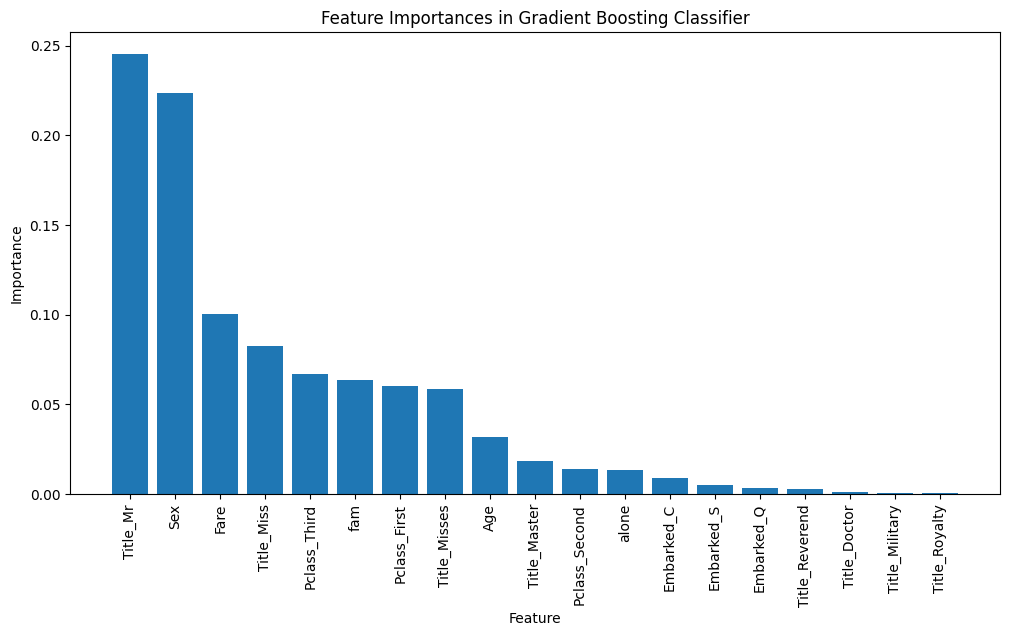

In [16]:
import matplotlib.pyplot as plt

# Accessing feature importances
feature_importances = model.feature_importances_

# Visualizing feature importances
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances in Gradient Boosting Classifier")
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [17]:
# CREATE PREDICTIONS
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': submissionPredictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
